# Imports

In [50]:
import numpy as np
#import pyaudio
import time
import matplotlib.pyplot as plt
%matplotlib inline

import essentia
# as there are 2 operating modes in essentia which have the same algorithms,
# these latter are dispatched into 2 submodules:

import essentia.standard
import essentia.streaming

# let's have a look at what is in there
#print dir(essentia.streaming)

# Essentia tutorial

## Standard processing

### Load data

In [2]:
# Essentia has a selection of audio loaders:
#
#  - AudioLoader: the basic one, returns the audio samples, sampling rate and number of channels
#  - MonoLoader: which returns audio, down-mixed and resampled to a given sampling rate
#  - EasyLoader: a MonoLoader which can optionally trim start/end slices and rescale according
#                to a ReplayGain value
#  - EqloudLoader: an EasyLoader that applies an equal-loudness filtering on the audio
#

# we start by instantiating the audio loader:
loader = essentia.standard.MonoLoader(filename = 'data/maps/MAPS_AkPnBcht_1/AkPnBcht/ISOL/CH/MAPS_ISOL_CH0.1_F_AkPnBcht.wav')

# and then we actually perform the loading:
audio = loader()

# by default, the MonoLoader will output audio with 44100Hz samplerate


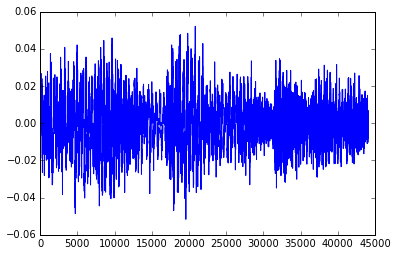

In [3]:
plt.plot(audio[1*44100:2*44100])
#show() # unnecessary if you started "ipython --pylab"

### Initialize functions

In [4]:
from essentia.standard import *

w = Windowing(type = 'hann')
# Applies windowing to audio signals. It optionally applies zero-phase windowing and optionally adds zero-padding.
# The resulting windowed frame size is equal to the incoming frame size plus the number of padded zeros. 
# The available windows are normalized (to have an area of 1) and then scaled by a factor of 2.
# Parms:
#  size (integer ∈ [2, ∞), default = 1024) : the window size
#  type (string ∈ {hamming, hann, triangular, square, blackmanharris62, blackmanharris70, blackmanharris74, 
#        blackmanharris92}, default = hann) : the window type, which can be 'hamming', 'hann', 'triangular',
#       'square' or 'blackmanharrisXX'
#  zeroPadding (integer ∈ [0, ∞), default = 0) : the size of the zero-padding
#  zeroPhase (bool ∈ {true, false}, default = true) a boolean value that enables zero-phase windowing

spectrum = Spectrum()
# Calculates the magnitude spectrum of an array of Reals. The resulting magnitude spectrum has a size 
# which is half the size of the input array plus one. Outputs spectrum (vector_real) - the magnitude spectrum
# of the input audio signal
# Parms: 
#  size (integer ∈ [1, ∞), default = 2048) : the expected size of the input audio signal 

mfcc = MFCC()
# Computes the mel-frequency cepstrum coefficients. As there is no standard implementation, the MFCC-FB40
# is used by default e.g.,: filterbank of 40 bands from 0 to 11000Hz, take the log value of the spectrum 
# energy in each mel band, DCT of the 40 bands down to 13 mel coefficients. 
# Outputs: 
#  bands (vector_real) - the energies in mel bands
#  mfcc (vector_real) - the mel frequency cepstrum coefficients
# Parms: 
#  highFrequencyBound (real ∈ (0, ∞), default = 11000) : the upper bound of the frequency range [Hz]
#  inputSize (integer ∈ (1, ∞), default = 1025) : the size of input spectrum
#  lowFrequencyBound (real ∈ [0, ∞), default = 0) : the lower bound of the frequency range [Hz]
#  numberBands (integer ∈ [1, ∞), default = 40) : the number of mel-bands in the filter
#  numberCoefficients (integer ∈ [1, ∞), default = 13) : the number of output mel coefficients
#  sampleRate (real ∈ (0, ∞), default = 44100) : the sampling rate of the audio signal [Hz]
                               
# let's have a look at the inline help. you can also see it by typing "MFCC?" in IPython. 
#help(MFCC)


### Magnitude of the audio input spectrum

Showing distribution by window type. 

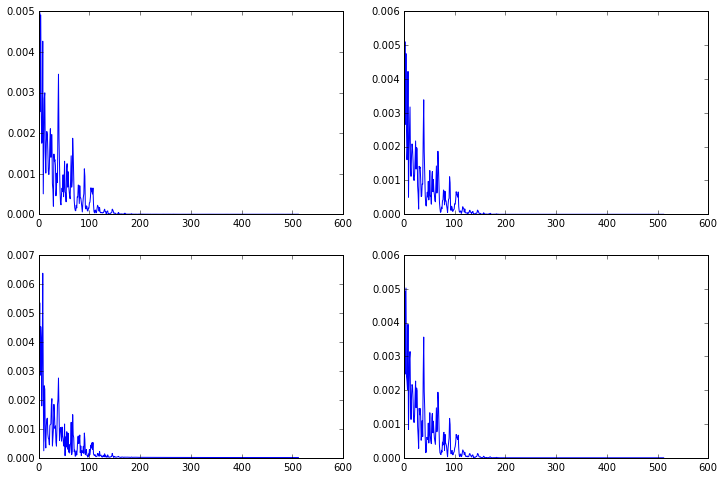

In [23]:
frame = audio[1*44100 : 1*44100 + 1024]

plt.figure(figsize=(12, 8))
#plt.rcParams['figure.figsize'] = (12.0, 8.0)
#plt.subplots_adjust(wspace=0, hspace=0)

w_hm = Windowing(type = 'hamming')
spec = spectrum(w_hm(frame))
plt.subplot(2,2,1); plt.plot(spec)

w_tr = Windowing(type = 'triangular')
spec = spectrum(w_tr(frame))
plt.subplot(2,2,2); plt.plot(spec)

w_sq = Windowing(type = 'square')
spec = spectrum(w_sq(frame))
plt.subplot(2,2,3); plt.plot(spec)

w_hn = Windowing(type = 'hann')
spec = spectrum(w_hn(frame))
plt.subplot(2,2,4); plt.plot(spec)

### Mel-frequency cepstrum coefficients

Showing fingerprint (every 512 ms?) by window type.

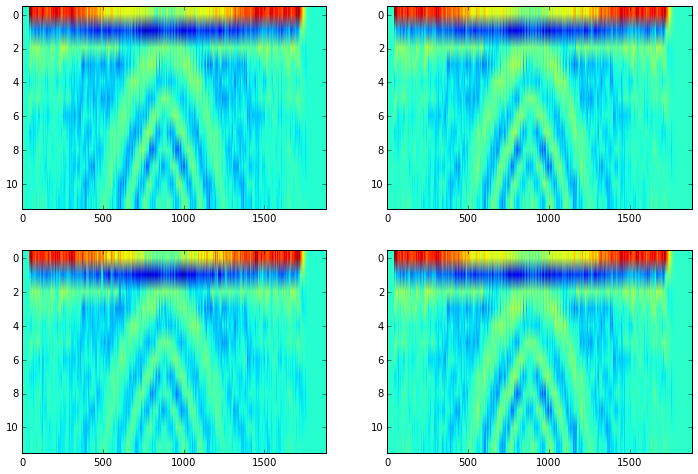

In [24]:
plt.figure(figsize=(12, 8))

mfccs = [] 
for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
    mfcc_bands, mfcc_coeffs = mfcc(spectrum(w_hm(frame))) # perform mfcc on spectrum returning bands, coefficients
    mfccs.append(mfcc_coeffs)
mfccs = essentia.array(mfccs).T # transpose, then convert list to an essentia.array first (== numpy.array of floats)
plt.subplot(2,2,1); plt.imshow(mfccs[1:,:], aspect = 'auto')

#****

mfccs = [] 
for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
    mfcc_bands, mfcc_coeffs = mfcc(spectrum(w_tr(frame))) # perform mfcc on spectrum returning bands, coefficients
    mfccs.append(mfcc_coeffs)  
mfccs = essentia.array(mfccs).T # transpose, then convert list to an essentia.array first (== numpy.array of floats)
plt.subplot(2,2,2); plt.imshow(mfccs[1:,:], aspect = 'auto')

#****

mfccs = [] 
for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
    mfcc_bands, mfcc_coeffs = mfcc(spectrum(w_sq(frame))) # perform mfcc on spectrum returning bands, coefficients
    mfccs.append(mfcc_coeffs)
mfccs = essentia.array(mfccs).T # transpose, then convert list to an essentia.array first (== numpy.array of floats)
plt.subplot(2,2,3); plt.imshow(mfccs[1:,:], aspect = 'auto')

#****

mfccs = [] 
for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
    mfcc_bands, mfcc_coeffs = mfcc(spectrum(w_hn(frame))) # perform mfcc on spectrum returning bands, coefficients
    mfccs.append(mfcc_coeffs)
        
mfccs = essentia.array(mfccs).T # transpose, then convert list to an essentia.array first (== numpy.array of floats)
plt.subplot(2,2,4); plt.imshow(mfccs[1:,:], aspect = 'auto')


# Ignored the first MFCC coefficient to disregard the power of the signal and only plot its spectral shape
#plt.imshow(mfccs[1:,:], aspect = 'auto')


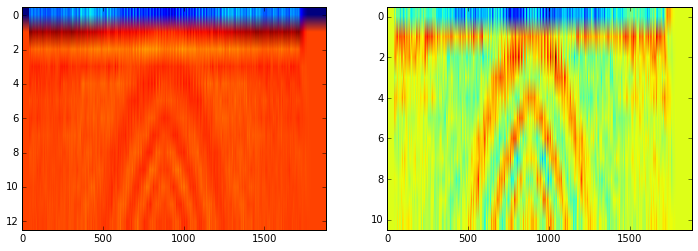

In [25]:
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1); plt.imshow(mfccs[:,:], aspect = 'auto')

plt.subplot(1,2,2); plt.imshow(mfccs[2:,:], aspect = 'auto')

### FFT

Not working.

In [26]:
# FFT() would return the complex FFT, here we just want the magnitude spectrum
fft = FFT()
# Computes the positive complex STFT (Short-term Fourier transform) of an array of Reals using the FFT algorithm. 
# The resulting fft has a size of (s/2)+1, where s is the size of the input frame. 
# At the moment FFT can only be computed on frames which size is even and non zero, otherwise exception.


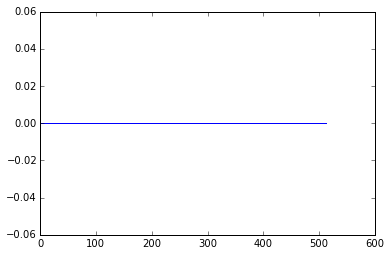

In [33]:
fftb = fft(w_hn(frame))

plt.plot(fftb)


### Pooling

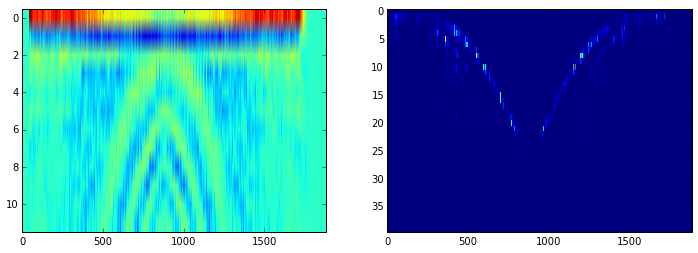

In [38]:
pool = essentia.Pool()

# A Pool is a container similar a Python dict which can contain any type of values... like a directory. 
# So, if you're going to apply diff functions to a single file, store their output centrally in the pool.
# Values are stored using a name which represent the path to these values where dot (‘.’) chars are separators. 
# Other pool advantage: data you get out of it is already in an essentia.array format, so you can transpose (.T) it

for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
    mfcc_bands, mfcc_coeffs = mfcc(spectrum(w_hn(frame)))
    pool.add('lowlevel.mfcc', mfcc_coeffs)
    pool.add('lowlevel.mfcc_bands', mfcc_bands)

plt.figure(figsize=(12, 4))
plt.subplot(1,2,1); plt.imshow(pool['lowlevel.mfcc'].T[1:,:], aspect = 'auto')
plt.subplot(1,2,2); plt.imshow(pool['lowlevel.mfcc_bands'].T, aspect = 'auto', interpolation = 'nearest')

### Save pool

In [41]:
# Writing results to file using the YamlOutput algorithm, which writes a pool in a file using the YAML or JSON format.
output = YamlOutput(filename = 'mfcc.sig') # use "format = 'json'" for JSON output
output(pool)

# or as a one-liner:
#YamlOutput(filename = 'mfcc.sig')(pool)

In [42]:
# Assume we only want mean and variance of the frames. Use PoolAggregator on pool to get a new pool with aggregations.
aggrPool = PoolAggregator(defaultStats = [ 'mean', 'var' ])(pool)

print 'Original pool descriptor names:'
print pool.descriptorNames()
print
print 'Aggregated pool descriptor names:'
print aggrPool.descriptorNames()

# and ouput those results in a file
YamlOutput(filename = 'mfccaggr.sig')(aggrPool)

Original pool descriptor names:
['lowlevel.mfcc', 'lowlevel.mfcc_bands']

Aggregated pool descriptor names:
['lowlevel.mfcc.mean', 'lowlevel.mfcc.var', 'lowlevel.mfcc_bands.mean', 'lowlevel.mfcc_bands.var']


## Stream processing

In [43]:
import essentia
from essentia.streaming import *

In [44]:
# and instantiate our algorithms

loader = MonoLoader(filename = 'data/maps/MAPS_AkPnBcht_1/AkPnBcht/ISOL/CH/MAPS_ISOL_CH0.1_F_AkPnBcht.wav')
frameCutter = FrameCutter(frameSize = 1024, hopSize = 512)
w = Windowing(type = 'hann')
spec = Spectrum()
mfcc = MFCC()


In [45]:
# In streaming, instead of calling algorithms like functions, we need to
# connect their inputs and outputs. This is done using the >> operator
#
# The graph we want to connect looks like this:
#  ____________       _________________       ________________       __________________
# /            \     /                 \     /                \     /                  \
# | MonoLoader |     |   FrameCutter   |     |   Windowing    |     |     Spectrum     |
# |            |     |                 |     |                |     |                  |
# |     audio -+-->--+- signal  frame -+-->--+- frame  frame -+-->--+- frame spectrum -+-->-\
# \____________/     \_________________/     \________________/     \__________________/    |
#                                                                                           |
#  /----------------------------------------------------------------------------------------/
#  |    ___________________
#  |   /                   \
#  |   |      MFCC         |
#  |   |            bands -+-->-- ???
#  \->-+- spectrum         |
#      |             mfcc -+-->-- ???
#      \___________________/
#

loader.audio >> frameCutter.signal
frameCutter.frame >> w.frame >> spec.frame
spec.spectrum >> mfcc.spectrum


<essentia.streaming._StreamConnector instance at 0x129d2e170>

In [46]:
# When building a network, all inputs need to be connected, no matter what, otherwise the network
# cannot be started

essentia.run(loader)


RuntimeError: MFCC::bands is not connected to any sink...

In [47]:
#  ____________       _________________       ________________       __________________
# /            \     /                 \     /                \     /                  \
# | MonoLoader |     |   FrameCutter   |     |   Windowing    |     |     Spectrum     |
# |            |     |                 |     |                |     |                  |
# |     audio -+-->--+- signal  frame -+-->--+- frame  frame -+-->--+- frame spectrum -+-->-\
# \____________/     \_________________/     \________________/     \__________________/    |
#                                                                                           |
#  /----------------------------------------------------------------------------------------/
#  |    ___________________              _________
#  |   /                   \            /         \
#  |   |      MFCC         |      /-->--+ NOWHERE |
#  |   |            bands -+-->--/      \_________/
#  \->-+- spectrum         |
#      |             mfcc -+-->--\       _____________________
#      \___________________/      \     /                     \
#                                  -->--+ Pool: lowlevel.mfcc |
#                                       \_____________________/

pool = essentia.Pool()

mfcc.bands >> None
mfcc.mfcc >> (pool, 'lowlevel.mfcc')

essentia.run(loader)

print 'Pool contains %d frames of MFCCs' % len(pool['lowlevel.mfcc'])


Pool contains 1884 frames of MFCCs


In [48]:
# Let's try writing directly to a text file, no pool and no yaml files

# we first need to disconnect the old connection to the pool to avoid putting the same data in there again
mfcc.mfcc.disconnect((pool, 'lowlevel.mfcc'))

# we create a FileOutput
fileout = FileOutput(filename = 'mfccframes.txt')

# and connect it: it is a special connection as it has no input, because it can actually
# take any type of input (the other algorithms will complain if you try to connect an output
# to an input of a different type)
mfcc.mfcc >> fileout

# reset the network otherwise the loader in particular will not do anything useful
essentia.reset(loader)

# and rerun it!
essentia.run(loader)



# Learn to map sound to notes

1. Take professional music sound files
2. Play, logging spectrum (frequency / time) and other attributes
    a. https://github.com/tyiannak/pyAudioAnalysis/wiki/3.-Feature-Extraction, OR
    b. 
3. Predict notes based on sound
    a. input spectrum is the "X"
    b. sheet music notes are the "y" (notes A, B, C, etc.)

# V1: Download piano train / test data

You'll need to request access at: http://www.tsi.telecom-paristech.fr/aao/en/2010/07/08/maps-database-a-piano-database-for-multipitch-estimation-and-automatic-transcription-of-music/. It takes a day or so to get credentials. As there are some peculularities about how to down load the data, the best bet is to use Filezilla (https://filezilla-project.org/). Ensure your "Host" protocl prefix is "fpes://". 


# V1: Generate harp note / chord train / test files

Garageband or other to generate:
1. individual instrument note (pitch?), chord by major/minor, octave, inversion
2. sequence files w/ varying amounts of spacing
3. mp3's of classical music for which you can easily veryify the notes


# V2: Standard: Fingerprint music files

In [ ]:
# use FFT, MFCC, etc to create a fignerprint of each of the music files s/t when user starts playing, you can take notes they've played and match 

# V2: Streaming: Extract note Sample

# V2: Streaming: Search / match sample to fingerprints

# Establish stream

Use pyaudio to instantiate stream for practice session

In [ ]:
WIDTH = 2
CHANNELS = 2
RATE = 44100

p = pyaudio.PyAudio()

def callback(in_data, frame_count, time_info, status):
    return (in_data, pyaudio.paContinue)

stream = p.open(format=p.get_format_from_width(WIDTH),
                channels=CHANNELS,
                rate=RATE,
                input=True,
                output=True,
                stream_callback=callback)

stream.start_stream()

while stream.is_active():
    time.sleep(0.1)

stream.stop_stream()
stream.close()

p.terminate()

# Display mode

1. Accept song selection
2. Load / display sheet music
3. Listen for start
4. Recieve sounds / translate notes
5. Track progress w/ vertical bar
6. Spot repeats re-setting tracking bar

In [ ]:
# https://github.com/tyiannak/pyAudioAnalysis
# http://essentia.upf.edu/documentation/


# Evaluate mode

1. display mode functionality including tracking progress
2. record playing. overlay repeats. you're tracking stats. so, obj s/b:
    a. to get through song re-playing pieces as required, THEN
    b. to get through song cleanly
3. comparing played to professional
    a. option to play:
        i. metrinome 
        ii. professional a low volume
4. identify discrpancies (timing after prior note, incorrect note)
    a. Gaia, a C++ library with python bindings which implement similarity measures and classification on the results of audio analysis, and generate classification models that Essentia can use to compute high-level description of music.
5. show discrepancies
    a. accept tolerances (+/- time, other?)
    b. show played note in red (i.e., before/after, above/below).
6. show / log statistics
    a. accuracy
    b. similarity
    c. error types and frequency distribution
        i. early,
        ii. late
        iii. wrong note
    d. problem areas

# Interactive mode

1. evaluate mode functionality
2. prompt session info and imprint voice of user for command interface
    a. "this is []. the date is []. i'll be practicing for about [] minutes."
3. voice commands
    a. "replay [] notes" - defaults to: 5 notes, played version
    b. "replay base [] notes"
    c. "loop [] notes" - 
        ii. Loop [] notes / Stop Loop
2. 

# References

This project would not be possible without the invaluable assistance of:

## Training data

The MAPS piano data set. Roughly 40G of piano notes, chords, music assembled by V. Emiya for her PhD thesis at Telecom ParisTech/ENST in 2008 and in conjunction with R. Badeau, B. David for their paper "Multipitch estimation of piano sounds using a new probabilistic spectral smoothness principle"<cite data-cite="emiya2010multipitch"></cite>


In [ ]:
# for installing latex, bibtex and pdf-ing jupyter notenooks: https://www.youtube.com/watch?v=m3o1KXA1Rjk